# Home World: Assess Sales Outlets' Performance

### **Task**
Assess the performance of the chain's sales outlets.
The dataset contains data on purchases made at the building-material retailer Home World. All of its customers have membership cards. Moreover, they can become members of the store's loyalty program for $20 per month. The program includes discounts, information on special offers, and gifts.


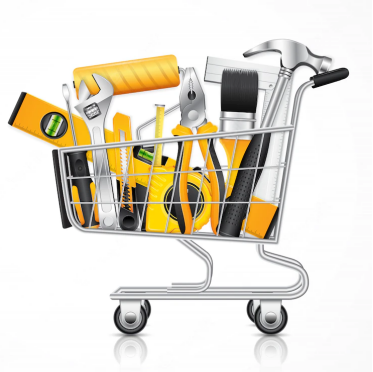

## Table of Contents

* [Data Preprocessing](#step1)
	* [Retail Table](#s1a)
	* [Product Table](#s1b)
    <br><br>
* [Exploratory Data Analysis](#step2)
<br><br>
* [Checking the performance per period](#step3)
	* [month-over-month (MoM) growth](#s3a)
	* [Week-over-Week (WoW) growth](#s3b)
	* [Period Analysis](#s3c)
<br><br>    
* [General Metrics](#step4)    
    * [Average Order Value](#s4a)
    * [Basket size](#s4b)
    * [Best Sellers](#s4c)
	* [Best-Seller and  Best-Revenue products](#s4d)
<br><br>
* [Customers Behavior](#step5)
    * [The No_id Effect](#s5a)
    * [Cohort Analysis of the group](#s5b)
	* [Cohort Analysis Observations](#s5c)
    * [Predictive Customer Lifetime Value (CLV)](#s5d)
 <br><br>   
* [Loyalty Program Analysis](#step6)
	* [Loyalty Participation Rate](#s6a)
	* [Repeat Purchase Rate (RPR)](#s6b)
	* [Loyal Customer Rate (LCR)](#s6c)
	* [Average Order Value - AOV](#s6d)
	* [Loyalty Program Observations](#s6e)
<br><br>    
* [Hypothesis on the Equality of the member and non-members of the Loyalty Program](#step7)
<br><br>
* [Shops Study](#step8)
	* [Best day of the week to sell](#s8a)
<br><br>    
* [General Conclusions](#step9)
<br><br>
* Annexes:
* [Decomposition (Annex 01)](#A1)
* [Documentation (Annex 02)](#A2)
* [Metrics To find - checklist (Annex 03)](#A3)
* [Links for external parts of the work (Annex 04)](#A4)
* [Extra - Printing Cashier Receipts (Annex 05)](#A5)


<hr>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import datetime as dt
from datetime import timedelta as td 
import scipy.stats as st
import lifetimes
from lifetimes import BetaGeoFitter # BG/NBD
from lifetimes import GammaGammaFitter # Gamma-Gamma Model
from lifetimes.plotting import plot_frequency_recency_matrix
%matplotlib inline


<a class="anchor" id="step1"></a>
# Data Preprocessing

In [4]:
# The table have to be downloaded from the web to be worked locally

retail = pd.read_csv('retail_dataset_us.csv')
product = pd.read_csv('product_codes_us.csv', sep = ";")


In [5]:
#adjusting the columns names
retail.columns= retail.columns.str.lower()
product.columns= product.columns.str.lower()

<a class="anchor" id="s1a"></a>
## Retail Table

In [6]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105335 entries, 0 to 105334
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   purchaseid       105335 non-null  object 
 1   item_id          105335 non-null  object 
 2   quantity         105335 non-null  int64  
 3   purchasedate     105335 non-null  object 
 4   customerid       69125 non-null   float64
 5   loyalty_program  105335 non-null  int64  
 6   shopid           105335 non-null  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 5.6+ MB


In [7]:
retail.head()

purchaseid item_id  quantity         purchasedate  customerid  \
0     538280   21873        11  2016-12-10 12:50:00     18427.0   
1     538862   22195         0  2016-12-14 14:11:00     22389.0   
2     538855   21239         7  2016-12-14 13:50:00     22182.0   
3     543543   22271         0  2017-02-09 15:33:00     23522.0   
4     543812   79321         0  2017-02-13 14:40:00     23151.0   

   loyalty_program   shopid  
0                0   Shop 3  
1                1   Shop 2  
2                1   Shop 3  
3                1  Shop 28  
4                1  Shop 28

In [8]:
retail.describe(include='all')

purchaseid item_id       quantity         purchasedate    customerid  \
count      105335  105335  105335.000000               105335  69125.000000   
unique       4894    3159            NaN                 4430           NaN   
top        537434  85123A            NaN  2016-12-06 16:57:00           NaN   
freq          675     565            NaN                  675           NaN   
mean          NaN     NaN       7.821218                  NaN  21019.302047   
std           NaN     NaN     327.946695                  NaN   1765.444679   
min           NaN     NaN  -74216.000000                  NaN  18025.000000   
25%           NaN     NaN       0.000000                  NaN  19544.000000   
50%           NaN     NaN       2.000000                  NaN  20990.000000   
75%           NaN     NaN       7.000000                  NaN  22659.000000   
max           NaN     NaN   74214.000000                  NaN  23962.000000   

        loyalty_program  shopid  
count     105335.000000  105335  
unique              NaN      31  
top                 NaN  Shop 0  
freq                NaN   38389  
mean           0.226345     NaN  
std            0.418467     NaN  
min            0.000000     NaN  
25%            0.000000     NaN  
50%            0.000000     NaN  
75%            0.000000     NaN  
max            1.000000     NaN

### Duplicated Values

In [9]:
retail[retail.duplicated()].sort_values('purchaseid').sample(10)

purchaseid item_id  quantity         purchasedate  customerid  \
97053     542401   22562         0  2017-01-27 15:51:00     20220.0   
44258     540247   84375         0  2017-01-05 15:56:00     21143.0   
82785     539075   21086         0  2016-12-15 17:28:00     22868.0   
32146     536464   22866         0  2016-12-01 12:23:00     23647.0   
90553     540839   22284         0  2017-01-11 15:42:00     22470.0   
65250     538313   22725         0  2016-12-10 13:50:00     21193.0   
60994     539181   21985        11  2016-12-16 11:51:00     18427.0   
34426     537781   22759         0  2016-12-08 12:46:00     23020.0   
76168     538051   22659         1  2016-12-09 13:24:00     23720.0   
99503     537208   21034         0  2016-12-05 15:12:00     21568.0   

       loyalty_program   shopid  
97053                0   Shop 5  
44258                0  Shop 24  
82785                1   Shop 7  
32146                1   Shop 6  
90553                1  Shop 29  
65250                0   Shop 7  
60994                0  Shop 22  
34426                1  Shop 13  
76168                1  Shop 15  
99503                0   Shop 8

In [10]:
#There are some duplicated values on the dataset
print("There are {} duplicated values and it is about {:.2%} of the whole dataset" 
      .format(len(retail[retail.duplicated()]),len(retail[retail.duplicated()])/len(retail)))

There are 1033 duplicated values and it is about 0.98% of the whole dataset


In [11]:
retail=retail.drop_duplicates().reset_index(drop=True)

#### Duplicated Values
- There are 1033 duplicated values and it is about 0.98% of the whole dataset
- We should drop those values to have a clean dataset 

<hr>

### Dates

In [12]:
#changing purchasedate into datetime
retail.purchasedate=pd.to_datetime(retail.purchasedate)
retail.dtypes

purchaseid                 object
item_id                    object
quantity                    int64
purchasedate       datetime64[ns]
customerid                float64
loyalty_program             int64
shopid                     object
dtype: object

In [13]:
retail['purchase_day'] = retail.purchasedate.dt.date
retail['week'] = retail['purchasedate'].astype('datetime64[W]')
retail['week_day']=retail['purchasedate'].dt.day_name()
retail['month']=retail['purchasedate'].dt.month_name()
#retail['month2'] = retail['purchasedate'].astype('datetime64[M]')



In [14]:
retail.head()

purchaseid item_id  quantity        purchasedate  customerid  \
0     538280   21873        11 2016-12-10 12:50:00     18427.0   
1     538862   22195         0 2016-12-14 14:11:00     22389.0   
2     538855   21239         7 2016-12-14 13:50:00     22182.0   
3     543543   22271         0 2017-02-09 15:33:00     23522.0   
4     543812   79321         0 2017-02-13 14:40:00     23151.0   

   loyalty_program   shopid purchase_day       week   week_day     month  
0                0   Shop 3   2016-12-10 2016-12-08   Saturday  December  
1                1   Shop 2   2016-12-14 2016-12-08  Wednesday  December  
2                1   Shop 3   2016-12-14 2016-12-08  Wednesday  December  
3                1  Shop 28   2017-02-09 2017-02-09   Thursday  February  
4                1  Shop 28   2017-02-13 2017-02-09     Monday  February

In [15]:
retail.groupby('purchase_day')['week_day'].max().reset_index().head(10)

purchase_day   week_day
0   2016-12-01   Thursday
1   2016-12-02     Friday
2   2016-12-03   Saturday
3   2016-12-05     Monday
4   2016-12-06    Tuesday
5   2016-12-07  Wednesday
6   2016-12-08   Thursday
7   2016-12-09     Friday
8   2016-12-10   Saturday
9   2016-12-12     Monday

In [16]:
retail.groupby(['purchasedate','week_day'])['purchaseid'].count().reset_index()

purchasedate  week_day  purchaseid
0    2016-12-01 08:26:00  Thursday           7
1    2016-12-01 08:28:00  Thursday           2
2    2016-12-01 08:34:00  Thursday          16
3    2016-12-01 08:35:00  Thursday           1
4    2016-12-01 08:45:00  Thursday          20
...                  ...       ...         ...
4425 2017-02-28 16:47:00   Tuesday         225
4426 2017-02-28 16:50:00   Tuesday         179
4427 2017-02-28 16:59:00   Tuesday         167
4428 2017-02-28 17:01:00   Tuesday          14
4429 2017-02-28 17:04:00   Tuesday           1

[4430 rows x 3 columns]

In [17]:
retail.groupby(['week','shopid'])['purchaseid'].count().reset_index()

week   shopid  purchaseid
0   2016-12-01   Shop 0        6366
1   2016-12-01   Shop 1         325
2   2016-12-01  Shop 10         498
3   2016-12-01  Shop 11         343
4   2016-12-01  Shop 12         279
..         ...      ...         ...
386 2017-02-23   Shop 5         144
387 2017-02-23   Shop 6          87
388 2017-02-23   Shop 7          66
389 2017-02-23   Shop 8         175
390 2017-02-23   Shop 9          74

[391 rows x 3 columns]

In [18]:
print(retail['purchase_day'].min() ,retail['purchase_day'].max() )

2016-12-01 2017-02-28


In [19]:
retail.purchase_day=pd.to_datetime(retail.purchase_day)
retail.dtypes

purchaseid                 object
item_id                    object
quantity                    int64
purchasedate       datetime64[ns]
customerid                float64
loyalty_program             int64
shopid                     object
purchase_day       datetime64[ns]
week               datetime64[ns]
week_day                   object
month                      object
dtype: object

In [20]:
len(retail[retail.week_day == 'Sunday'])

0

#### Dates
- The data cointains operations in a period of 3 months from December 2016 to February 2017.
- The shops are open from Monday to Saturday, closing on Sundays

<hr>

### Purchase ID

In [21]:
retail.purchaseid.nunique()

4894

In [22]:
retail[retail.purchaseid=='537434']

purchaseid item_id  quantity        purchasedate  customerid  \
62         537434   22560         2 2016-12-06 16:57:00         NaN   
152        537434   21328         2 2016-12-06 16:57:00         NaN   
410        537434   84380         2 2016-12-06 16:57:00         NaN   
561        537434   22735         1 2016-12-06 16:57:00         NaN   
579        537434   22837         1 2016-12-06 16:57:00         NaN   
...           ...     ...       ...                 ...         ...   
103973     537434   21143         0 2016-12-06 16:57:00         NaN   
104129     537434   21361         0 2016-12-06 16:57:00         NaN   
104144     537434   22963         1 2016-12-06 16:57:00         NaN   
104167     537434   22749         0 2016-12-06 16:57:00         NaN   
104284     537434  84536A         5 2016-12-06 16:57:00         NaN   

        loyalty_program  shopid purchase_day       week week_day     month  
62                    0  Shop 0   2016-12-06 2016-12-01  Tuesday  December  
152                   0  Shop 0   2016-12-06 2016-12-01  Tuesday  December  
410                   0  Shop 0   2016-12-06 2016-12-01  Tuesday  December  
561                   0  Shop 0   2016-12-06 2016-12-01  Tuesday  December  
579                   0  Shop 0   2016-12-06 2016-12-01  Tuesday  December  
...                 ...     ...          ...        ...      ...       ...  
103973                0  Shop 0   2016-12-06 2016-12-01  Tuesday  December  
104129                0  Shop 0   2016-12-06 2016-12-01  Tuesday  December  
104144                0  Shop 0   2016-12-06 2016-12-01  Tuesday  December  
104167                0  Shop 0   2016-12-06 2016-12-01  Tuesday  December  
104284                0  Shop 0   2016-12-06 2016-12-01  Tuesday  December  

[675 rows x 11 columns]

<hr>

### Customer ID

In [23]:
#There are some null values in customerid
print("There are {} null customer values and it is about {:.2%} of the whole dataset" 
      .format(len(retail[retail.customerid.isnull()]),len(retail[retail.customerid.isnull()])/len(retail)))


There are 36148 null customer values and it is about 34.66% of the whole dataset


In [24]:
# Quick view - null customerid
retail[retail.customerid.isnull()].groupby('shopid').agg({'purchaseid':'count', 'item_id':'unique', 'quantity':'sum'}).reset_index()

shopid  purchaseid                                            item_id  \
0   Shop 0       35952  [22189, 79321, 22891, 22197, 22300, 21154, 846...   
1  Shop 21          14  [22749, 21242, 22450, 22722, 22451, 22721, 475...   
2  Shop 23           2                                           [72802B]   
3  Shop 25          53  [20961, 20725, 21981, 22636, 22652, 21947, 219...   
4   Shop 6         127  [22730, 22963, 82482, 21888, 21896, 22865, 224...   

   quantity  
0     61849  
1        86  
2        -2  
3      1008  
4      1407

In [25]:
retail.customerid.fillna('no_id', inplace=True)

In [26]:
retail[retail.customerid=='no_id'].head()

purchaseid item_id  quantity        purchasedate customerid  \
6      540468   22189         0 2017-01-07 13:55:00      no_id   
7      541424   79321         1 2017-01-17 17:57:00      no_id   
8      538883   22891         0 2016-12-14 15:56:00      no_id   
11     541696   22197         4 2017-01-20 18:08:00      no_id   
16     539744   22300         5 2016-12-21 15:21:00      no_id   

    loyalty_program  shopid purchase_day       week   week_day     month  
6                 0  Shop 0   2017-01-07 2017-01-05   Saturday   January  
7                 0  Shop 0   2017-01-17 2017-01-12    Tuesday   January  
8                 0  Shop 0   2016-12-14 2016-12-08  Wednesday  December  
11                0  Shop 0   2017-01-20 2017-01-19     Friday   January  
16                0  Shop 0   2016-12-21 2016-12-15  Wednesday  December

- There are 36148 null customer values and it is about 34.66% of the whole dataset
- Those null values probably are referring to users that bought without idenfying themselves on the shop
- Let's change the null values to  *no_id*  
- Shop 0 is the great cause of the null customer values, let's check agin later for the shop 0 activities

<hr>

### Quantity 

In [27]:
#Let's check for the quantity negative values 
print("There are {} negative quantity values and it is about {:.2%} of the whole dataset" 
      .format(len(retail[retail.quantity<0]),len(retail[retail.quantity<0])/len(retail)))

There are 2076 negative quantity values and it is about 1.99% of the whole dataset


In [28]:
retail.item_id[retail.quantity<0].nunique()

950

In [29]:
#Let's check for the quantity values equal to zero
print("There are {} zero quantity values and it is about {:.2%} of the whole dataset" 
      .format(len(retail[retail.quantity==0]),len(retail[retail.quantity==0])/len(retail)))

There are 32362 zero quantity values and it is about 31.03% of the whole dataset


In [30]:
#Let's check for the quantity values greater than 50
print("There are {} high quantity values and it is about {:.2%} of the whole dataset" 
      .format(len(retail[retail.quantity>50]),len(retail[retail.quantity>50])/len(retail)))

There are 2155 high quantity values and it is about 2.07% of the whole dataset


In [31]:
fig = px.violin(retail,x='quantity')
fig.show()


In [32]:
retail[retail.quantity<0].groupby(['purchaseid','purchasedate']).agg({'shopid':'max', 'quantity':'sum', 'customerid':'max'}).reset_index()

purchaseid        purchasedate   shopid  quantity customerid
0        536589 2016-12-01 16:50:00   Shop 0       -11      no_id
1        536764 2016-12-02 14:42:00   Shop 0       -39      no_id
2        536996 2016-12-03 15:30:00   Shop 0       -21      no_id
3        536997 2016-12-03 15:30:00   Shop 0       -21      no_id
4        536998 2016-12-03 15:30:00   Shop 0        -7      no_id
...         ...                 ...      ...       ...        ...
1014    C545003 2017-02-25 12:46:00   Shop 8       -15    23910.0
1015    C545033 2017-02-25 16:26:00  Shop 24      -678    19835.0
1016    C545040 2017-02-27 10:25:00   Shop 4        -2    19363.0
1017    C545068 2017-02-27 15:07:00  Shop 13       -12    19836.0
1018    C545189 2017-02-28 15:19:00  Shop 27        -2    23520.0

[1019 rows x 5 columns]

In [33]:
retail[retail.quantity>70000]

purchaseid item_id  quantity        purchasedate customerid  \
68612     541431   23166     74214 2017-01-18 10:01:00    18025.0   

       loyalty_program   shopid purchase_day       week   week_day    month  
68612                0  Shop 15   2017-01-18 2017-01-12  Wednesday  January

In [34]:
retail[retail.quantity<-70000]

purchaseid item_id  quantity        purchasedate customerid  \
49166    C541433   23166    -74216 2017-01-18 10:17:00    18025.0   

       loyalty_program   shopid purchase_day       week   week_day    month  
49166                0  Shop 21   2017-01-18 2017-01-12  Wednesday  January

In [35]:
retail = retail[(retail.quantity>=0)& (retail.quantity<7000)]

In [36]:
len(retail[(retail.quantity<0)])

0

#### Quantity
- The negative numbers are about 2% and there is a possibility that those values are due mistype, product devolutions or administrative tasks (Bank charges / Amazon fees / Post) -  we can drop them from the dataset because it's impossible to have such negative numbers of quantity.
- On the other hand, the quantity equal to zero are more than 30% of the dataset, so we have to try to clarify what is the meaning of this large amount of registered products with  zero quantity.
- There are 2155 high quantity values and it is about 2.07% of the whole dataset greater than 50 unities but we can keep them as "big purchases"
- There is a extreme high quantity (74000 unities) that has also the same negative value from the same client and both transactions have a difference of 17 minutes among them (in different Shops!). So let's drop it to avoid deviation in the data

<hr>

### Shop id 

In [37]:
retail.shopid.nunique()

31

In [38]:
#Shop Activity
shops = retail.groupby('shopid')['purchaseid'].count().reset_index().sort_values('purchaseid', ascending = False)
shops.head()

shopid  purchaseid
0    Shop 0       37956
1    Shop 1        2645
7   Shop 15        2617
17  Shop 24        2535
15  Shop 22        2469

In [39]:
shops.purchaseid[shops.shopid=='Shop 0']/shops.purchaseid.sum()

0    0.371299
Name: purchaseid, dtype: float64

In [40]:
shops.purchaseid[shops.shopid!='Shop 0'].mean()

2142.3

In [41]:
len(retail[(retail.shopid=='Shop 0')&(retail.customerid.isnull())])

0

In [42]:
len(retail[(retail.shopid=='Shop 0')&(retail.customerid.isnull())&(retail.quantity<1)])

0

<hr>

#### Shop Id
- There are 31 shops in our dataset
- The Shop 0 is alone responsible for the 37% of the whole operations
- The shop 0 has almost 38000 operations when the average for the other 30 shops is around 2200 each
- The shop 0 has almost 36000 operations with a null customer id (more than 20000 of them with zero or negative quantity values)







<hr>

### Loyalty

In [43]:
retail.loyalty_program.value_counts()

0    79252
1    22973
Name: loyalty_program, dtype: int64

In [44]:
#Let's check for the loyalty program members 
print("There are {} loyalty program members and it is about {:.2%} of the whole dataset" 
      .format(len(retail[retail.loyalty_program==1]),len(retail[retail.loyalty_program==1])/len(retail)))

There are 22973 loyalty program members and it is about 22.47% of the whole dataset


#### Loyalty Program
- There are 22973 loyalty program members and it is about 22.47% of the whole dataset
- There is no Item value of 20,00 to be considered as the monthly Loyalty program fee

<hr>

<hr>

<a class="anchor" id="s1b"></a>
## Product Table

In [45]:
product.head()

productid  price_per_one
0     10002           0.85
1     10080           0.85
2     10120           0.21
3    10123C           0.65
4    10124A           0.42

In [46]:
product.describe(include='all')

productid  price_per_one
count       3159    3159.000000
unique      3159            NaN
top        10002            NaN
freq           1            NaN
mean         NaN       2.954495
std          NaN       7.213808
min          NaN       0.000000
25%          NaN       0.650000
50%          NaN       1.450000
75%          NaN       3.290000
max          NaN     175.000000

### Duplicated Values

In [47]:
len(product[product.duplicated()])

0

No duplicated values in product

<hr>

### Product Id


In [48]:
product.productid.nunique()

3159

In [49]:
product.head()

productid  price_per_one
0     10002           0.85
1     10080           0.85
2     10120           0.21
3    10123C           0.65
4    10124A           0.42

Apparently the productid and the item_id are the same, but let's chek if it's right

In [50]:


if list(product.productid.unique()).sort()== list(retail.item_id.unique()).sort():
    print( 'The product id and the Item id are the same' )
else:
    print( 'Forget it!' )

The product id and the Item id are the same


<hr>

### Price per one


In [51]:
product.price_per_one.describe()

count    3159.000000
mean        2.954495
std         7.213808
min         0.000000
25%         0.650000
50%         1.450000
75%         3.290000
max       175.000000
Name: price_per_one, dtype: float64

In [52]:
len(product[product.price_per_one==0])

382

In [53]:
len(product[product.price_per_one==20])

0

In [54]:
fig = px.box(product,x='price_per_one')
fig.show()

In [55]:
product.price_per_one[product.productid == 'BANK CHARGES']

3137    15.0
Name: price_per_one, dtype: float64

In [56]:
product.price_per_one[product.productid == 'POST']

3152    0.0
Name: price_per_one, dtype: float64

In [57]:
product.price_per_one[product.productid == 'AMAZONFEE']

3136    1.0
Name: price_per_one, dtype: float64

#### Price per one 

- This column presents all the prices applied to products and operations
- There are no negative and 382 zero price values in the dataset - We will have to drop both values to clean the data
- Some products that have negative quantities in the retails table (Bank Charges, Amazon fee) have positive values of price per one, indicating expenses for the company in the final computation
- The mean of the prices is 2.95 with prices with high values until 175,00 pulling this mean up


<hr>

<a class="anchor" id="step2"></a>
# Exploratory Data Analysis

## Creating an unified table

In [58]:
sales = retail.merge(product,left_on='item_id', right_on='productid')
sales['item_total']= sales['price_per_one']*sales['quantity']
#sales = sales[['customerid','purchaseid','purchasedate','item_id','price_per_one','quantity','item_total','loyalty_program','shopid']]
sales.sample(5)

purchaseid item_id  quantity        purchasedate customerid  \
62743     538163   22371         0 2016-12-09 17:27:00    23520.0   
31822     543428   22456         1 2017-02-08 11:36:00    23466.0   
86137     544788   22716        11 2017-02-23 12:18:00    18768.0   
31665     538379   22694         1 2016-12-12 11:26:00    22805.0   
436       541136   79321        23 2017-01-14 10:39:00    23908.0   

       loyalty_program   shopid purchase_day       week   week_day     month  \
62743                1   Shop 9   2016-12-09 2016-12-08     Friday  December   
31822                1   Shop 8   2017-02-08 2017-02-02  Wednesday  February   
86137                0   Shop 8   2017-02-23 2017-02-23   Thursday  February   
31665                1  Shop 20   2016-12-12 2016-12-08     Monday  December   
436                  1  Shop 28   2017-01-14 2017-01-12   Saturday   January   

      productid  price_per_one  item_total  
62743     22371           0.00        0.00  
31822     22456           4.25        4.25  
86137     22716           0.36        3.96  
31665     22694           2.10        2.10  
436       79321           0.00        0.00

In [59]:
# defining total amount by purchaseid
p_total = sales.groupby('purchaseid')['item_total'].sum().reset_index()
p_total.rename(columns = {'item_total':'purchase_total'}, inplace = True)
p_total

purchaseid  purchase_total
0        536365           62.80
1        536366            0.00
2        536367          169.93
3        536368           48.45
4        536369           10.90
...         ...             ...
3869     545214           96.27
3870     545215          277.60
3871     545216          303.47
3872     545217          284.09
3873     545218          388.02

[3874 rows x 2 columns]

In [60]:
p_total.purchase_total.describe()

count     3874.000000
mean       259.873268
std        638.973280
min          0.000000
25%         50.782500
50%        133.645000
75%        262.297500
max      13529.050000
Name: purchase_total, dtype: float64

In [61]:
fig = px.box(p_total,x='purchase_total')
fig.show()

In [62]:
#dict_total = pd.Series(p_total.purchase_total.values,index=p_total.purchaseid).to_dict()

In [63]:
dict_total = dict(zip(p_total.purchaseid, p_total.purchase_total))

In [64]:
sales['purchase_total']= sales['purchaseid'].map(dict_total)
sales.sort_values('purchaseid').head()

purchaseid item_id  quantity        purchasedate customerid  \
7953      536365  85123A         5 2016-12-01 08:26:00    23529.0   
17943     536365  84406B         7 2016-12-01 08:26:00    23529.0   
38267     536365   22752         1 2016-12-01 08:26:00    23529.0   
69967     536365   71053         5 2016-12-01 08:26:00    23529.0   
15464     536365  84029E         5 2016-12-01 08:26:00    23529.0   

       loyalty_program   shopid purchase_day       week  week_day     month  \
7953                 1  Shop 27   2016-12-01 2016-12-01  Thursday  December   
17943                1  Shop 27   2016-12-01 2016-12-01  Thursday  December   
38267                1  Shop 27   2016-12-01 2016-12-01  Thursday  December   
69967                1  Shop 27   2016-12-01 2016-12-01  Thursday  December   
15464                1  Shop 27   2016-12-01 2016-12-01  Thursday  December   

      productid  price_per_one  item_total  purchase_total  
7953     85123A           0.00        0.00            62.8  
17943    84406B           0.00        0.00            62.8  
38267     22752           7.65        7.65            62.8  
69967     71053           3.39       16.95            62.8  
15464    84029E           0.00        0.00            62.8

In [65]:
len(sales[sales.purchase_total==0])

808

In [66]:
#Dropping Total purchase = 0
sales = sales[sales.purchase_total>0]

In [67]:
#Dropping price per one = 0
sales = sales[sales.price_per_one>0]

In [68]:
sales = sales[sales.quantity>0]

In [69]:
sales.purchaseid.nunique()

3515

In [70]:
sales.customerid[sales.customerid!='no_id'].nunique()

1652

In [71]:
sales.shape

(58930, 15)

In [72]:

round(sales.item_total.sum(),2)

1006749.04

- There are 808 rows with the purchase_total equal to 0, so we can drop these rows from our data
- we are left with a clean table with 86041 rows and 3515 unique purchases made by 1652 known customers during the three months of the data
- All the stores sold a total of a little bit more than 1 million USD durin this period

<hr>

<a class="anchor" id="step3"></a>
## Checking the performance per period 
### discovering if some days have more sales than others 

In [73]:
week_check= sales.groupby('week').agg({'purchaseid':'nunique','item_total':'sum'}).reset_index()

week_check



week  purchaseid  item_total
0  2016-12-01         555   147888.65
1  2016-12-08         476   119164.02
2  2016-12-15         370    97367.57
3  2016-12-22          36     8612.94
4  2016-12-29          36     8645.30
5  2017-01-05         286   111453.58
6  2017-01-12         238    79587.05
7  2017-01-19         251    82760.12
8  2017-01-26         288    68675.05
9  2017-02-02         245    67397.30
10 2017-02-09         221    76356.09
11 2017-02-16         265    86426.36
12 2017-02-23         248    52415.01

In [74]:
week_check.item_total.sum()

1006749.04

In [75]:
fig = px.bar(week_check, x='week', y='purchaseid',
    #color = 'group', 
    
)

fig.add_hline(y=week_check.purchaseid.mean(),line_dash="dash", line_color="#c0c0c0")


fig.update_layout(
    title='Purchases by week',
    showlegend=True,
    #plot_bgcolor="#DDFFCC",
    margin=dict(t=50,l=10,b=10,r=10),
    font_color = "#281915"
)
fig.show() 

In [ ]:
fig = px.bar(week_check, x='week', y='item_total',
   #color = 'group',    
)
fig.add_hline(y=week_check.item_total.mean(),line_dash="dash", line_color="#c0c0c0")

fig.update_layout(
    title='Purchases by week ($)',
    showlegend=True,
    yaxis_title='total amount',
    #plot_bgcolor="#FFF",
    margin=dict(t=50,l=10,b=10,r=10),
    font_color = "#281915"
)
fig.show() 

In [77]:
week_check.purchaseid.mean()

270.38461538461536

In [78]:
week_check.item_total.mean()

77442.23384615385

In [79]:
week_check.sort_values('purchaseid', ascending = False)

week  purchaseid  item_total
0  2016-12-01         555   147888.65
1  2016-12-08         476   119164.02
2  2016-12-15         370    97367.57
8  2017-01-26         288    68675.05
5  2017-01-05         286   111453.58
11 2017-02-16         265    86426.36
7  2017-01-19         251    82760.12
12 2017-02-23         248    52415.01
9  2017-02-02         245    67397.30
6  2017-01-12         238    79587.05
10 2017-02-09         221    76356.09
3  2016-12-22          36     8612.94
4  2016-12-29          36     8645.30

In [80]:
week_check.sort_values('item_total', ascending = False)

week  purchaseid  item_total
0  2016-12-01         555   147888.65
1  2016-12-08         476   119164.02
5  2017-01-05         286   111453.58
2  2016-12-15         370    97367.57
11 2017-02-16         265    86426.36
7  2017-01-19         251    82760.12
6  2017-01-12         238    79587.05
10 2017-02-09         221    76356.09
8  2017-01-26         288    68675.05
9  2017-02-02         245    67397.30
12 2017-02-23         248    52415.01
4  2016-12-29          36     8645.30
3  2016-12-22          36     8612.94

In [81]:
week_day_check = sales.groupby('week_day').agg({'purchaseid':'nunique', 'item_total':'sum'}).reset_index()
week_day_check = week_day_check.reindex([1,4,5,3,0,2]).reset_index(drop=True)
week_day_check

week_day  purchaseid  item_total
0     Monday         351    64013.70
1    Tuesday         590   173521.77
2  Wednesday         607   215870.44
3   Thursday         696   177731.06
4     Friday         733   195428.99
5   Saturday         538   180183.08

In [82]:
fig = px.scatter(week_day_check, x='purchaseid', y='item_total',
    color = 'week_day', size = (week_day_check.purchaseid+(week_day_check.item_total/100))
    
)
fig.update_layout(
    title='Comparing the days of the week',
    showlegend=True,
    xaxis_title='number of purchases',
    yaxis_title='total amount',
     plot_bgcolor="#FFFFFF",
    xaxis_gridcolor="#cccfff",
    yaxis_gridcolor="#cccfff",
    margin=dict(t=50,l=10,b=10,r=10),
    font_color = "#1f4f79"
)
fig.show() 

In [83]:
week_day_check.sort_values('purchaseid', ascending = False)

week_day  purchaseid  item_total
4     Friday         733   195428.99
3   Thursday         696   177731.06
2  Wednesday         607   215870.44
1    Tuesday         590   173521.77
5   Saturday         538   180183.08
0     Monday         351    64013.70

In [84]:
week_day_check.sort_values('item_total', ascending = False)

week_day  purchaseid  item_total
2  Wednesday         607   215870.44
4     Friday         733   195428.99
5   Saturday         538   180183.08
3   Thursday         696   177731.06
1    Tuesday         590   173521.77
0     Monday         351    64013.70

<hr>

<a class="anchor" id="s3a"></a>
### month-over-month (MoM) growth
((Current Month’s Sales - Previous Month’s Sales) / Previous Month’s Sales) x 100 

In [85]:
mom_check = sales.groupby('month').agg({'purchaseid':'nunique', 'item_total':'sum'}).reset_index()
mom_check= mom_check.reindex([0,2,1]).reset_index(drop=True)
mom_check['mom'] = 0.0
for i in range(1,(len(mom_check))):
    mom_check['mom'][i]= ((mom_check['item_total'][i]/mom_check['item_total'][i-1])-1)*100


mom_check
#1006749.04

month  purchaseid  item_total        mom
0  December        1437   373033.18   0.000000
1   January        1038   333657.16 -10.555635
2  February        1040   300058.70 -10.069755

<hr>

<a class="anchor" id="s3b"></a>
### Week-over-Week (WoW) growth

In [86]:
wow_check = week_check.sort_values('week')

wow_check['wow']=0.0
for i in range(1,(len(week_check))):
    wow_check['wow'][i]= ((wow_check['item_total'][i]/wow_check['item_total'][i-1])-1)*100
wow_check['pwow']=0.0
for i in range(1,(len(wow_check))):
    wow_check['pwow'][i]= ((wow_check['purchaseid'][i]/wow_check['purchaseid'][i-1])-1)*100
wow_check

week  purchaseid  item_total          wow        pwow
0  2016-12-01         555   147888.65     0.000000    0.000000
1  2016-12-08         476   119164.02   -19.423147  -14.234234
2  2016-12-15         370    97367.57   -18.291134  -22.268908
3  2016-12-22          36     8612.94   -91.154201  -90.270270
4  2016-12-29          36     8645.30     0.375714    0.000000
5  2017-01-05         286   111453.58  1189.181174  694.444444
6  2017-01-12         238    79587.05   -28.591751  -16.783217
7  2017-01-19         251    82760.12     3.986917    5.462185
8  2017-01-26         288    68675.05   -17.019151   14.741036
9  2017-02-02         245    67397.30    -1.860574  -14.930556
10 2017-02-09         221    76356.09    13.292506   -9.795918
11 2017-02-16         265    86426.36    13.188562   19.909502
12 2017-02-23         248    52415.01   -39.352982   -6.415094

In [87]:
fig = px.line(wow_check,x="week", y="wow",title='WoW Revenue')
#adding reference line
fig.add_hline(y=wow_check['wow'].mean(),line_dash="dash", line_color="#c0c0c0")
fig.update_layout(
    showlegend=True,
    xaxis_title='Weeks',
    yaxis_title='total amount',
     plot_bgcolor="#FFFFFF",
    xaxis_gridcolor="#cccfff",
    yaxis_gridcolor="#cccfff",
    margin=dict(t=50,l=10,b=10,r=10),
    font_color = "#1f4f79",
    
)
fig.show()

In [88]:
fig = px.line(wow_check,x="week", y="pwow",title='WoW Purchases')
#adding reference line
fig.add_hline(y=wow_check['pwow'].mean(),line_dash="dash", line_color="#c0c0c0")
fig.update_layout(
    showlegend=True,
    xaxis_title='Weeks',
    yaxis_title='nu of purchases',
     plot_bgcolor="#FFFFFF",
    xaxis_gridcolor="#cccfff",
    yaxis_gridcolor="#cccfff",
    margin=dict(t=50,l=10,b=10,r=10),
    font_color = "#1f4f79",
)
fig.show()

In [89]:
((333657.16/373033.18)-1)*100

-10.555634756136179

In [90]:
mom_check.item_total.sum()

1006749.04

<a class="anchor" id="s3c"></a>
### Period Analysis
- The study was taken in 13 weeks, from Dec 1st 2016 to Feb 28 2017
- The total revenue for the whole period was around 1 Million
- There is a gap of two weeks from Dec 22th to Jan 4th almost without activity on the shops. Maybe caused by the Holidays
- The weekly average of purchases was 270 with an average revenue of around 77440
- The best week for business was from Dec 1st and Dec 7th, where both the number of purchases (555) and the amount expended (~148000) are higher than the rest of the weeks.
- The worst day of the week for the business are Mondays. Fridays have a greater number of purchases, but Wednesdays gathered the higher sales revenue for those months 
- The Metric MOM (month over Month) is showing a gradual decrease of ~10% each month From December to February
- The Metric WoW (Week over week) is showing a great variation of values, with a high peak on the week of Jan 5 2017 caused by the lack of movements in the two previous weeks.



<hr>

<a class="anchor" id="step4"></a>
# General Metrics

<a class="anchor" id="s4a"></a>
## Average Order Value 

In [91]:
AOV = sales.item_total.sum()/sales.purchaseid.nunique()
AOV

286.4150896159317

<hr>

<a class="anchor" id="s4b"></a>
## Basket size


In [92]:
b_size = sales.quantity.sum()/sales.purchaseid.nunique()
b_size

208.45917496443812

In [93]:
sales.head()

purchaseid item_id  quantity        purchasedate customerid  \
0     538280   21873        11 2016-12-10 12:50:00    18427.0   
2     540418   21873         1 2017-01-07 11:04:00      no_id   
3     541516   21873         2 2017-01-18 17:34:00      no_id   
4     541566   21873        35 2017-01-19 11:50:00    23401.0   
5     538843   21873         1 2016-12-14 13:18:00    21712.0   

   loyalty_program   shopid purchase_day       week   week_day     month  \
0                0   Shop 3   2016-12-10 2016-12-08   Saturday  December   
2                0   Shop 0   2017-01-07 2017-01-05   Saturday   January   
3                0   Shop 0   2017-01-18 2017-01-12  Wednesday   January   
4                1  Shop 22   2017-01-19 2017-01-19   Thursday   January   
5                0   Shop 9   2016-12-14 2016-12-08  Wednesday  December   

  productid  price_per_one  item_total  purchase_total  
0     21873           0.42        4.62          572.67  
2     21873           0.42        0.42          811.94  
3     21873           0.42        0.84          376.37  
4     21873           0.42       14.70          791.74  
5     21873           0.42        0.42           68.58

<hr>

<a class="anchor" id="s4c"></a>
## Best Sellers

In [94]:
best_seller = sales.groupby(['item_id', 'price_per_one'])[['quantity','item_total' ]].sum().sort_values('quantity', ascending = False).reset_index()
b_seller_list = best_seller.item_id.head()
best_seller.head()

item_id  price_per_one  quantity  item_total
0   84077           0.18     10126     1822.68
1   21212           0.40      9325     3730.00
2   22197           0.72      6953     5006.16
3   22693           0.94      6830     6420.20
4   22616           0.22      5764     1268.08

In [95]:
b_sell= sales[sales.item_id.isin(b_seller_list)]
b_s_cust= b_sell.customerid.nunique()-1 #dropping the "no_id values"
b_s_purch = b_sell[b_sell.customerid!='no_id'].purchaseid.nunique()
b_s_purch_noid = b_sell[b_sell.customerid=='no_id'].purchaseid.nunique()                    
print(b_s_cust, b_s_purch, b_s_purch_noid, b_s_purch_noid+b_s_purch)


353 459 124 583


In [96]:
best_revenue = best_seller.sort_values('item_total', ascending=False)
b_revenue_list = best_revenue.item_id.head()
best_revenue.head()

item_id  price_per_one  quantity  item_total
53   21623           6.38      2070    13206.60
30   21137           3.39      2711     9190.29
62   82484           4.77      1894     9034.38
5    22469           1.45      5602     8122.90
17   22189           2.31      3502     8089.62

In [97]:
best_revenue.item_total.head().unique()

array([13206.6 ,  9190.29,  9034.38,  8122.9 ,  8089.62])

In [98]:
b_rev= sales[sales.item_id.isin(b_revenue_list)]
b_r_cust= b_rev.customerid.nunique()-1 #dropping the "no_id values"
b_r_purch = b_rev[b_rev.customerid!='no_id'].purchaseid.nunique()
b_r_purch_noid = b_rev[b_rev.customerid=='no_id'].purchaseid.nunique()                    
print(b_r_cust, b_r_purch, b_r_purch_noid, b_r_purch_noid+b_s_purch)

365 499 71 530


In [99]:
fig = px.scatter(best_seller, x='quantity', y='item_total',
    color = 'item_id', size = (best_seller.quantity+best_seller.item_total)
    
)
fig.update_layout(
    title='Selling performance by product',
    showlegend=False,
    #plot_bgcolor="#DDFFCC",
    xaxis_title='Quantity of sold unities',
    yaxis_title='Total Revenue',
    margin=dict(t=50,l=10,b=10,r=10),
    plot_bgcolor="#FFFFFF",
    xaxis_gridcolor="#cccfff",
    yaxis_gridcolor="#cccfff",
    font_color = "#1f4f79",
)
fig.show() 

<a class="anchor" id="s4d"></a>
### Best-Seller and  Best-Revenue products
- The Best Seller products are the one that the people are buyin the most among all the catalogue.
- The top five best-seller products are 8407, 2122, 22197, 22693 that the sell quantity were respectively 10126, 9325, 6953, 6830, 5764 units each.
- Those Items were bought by 366 known users that made 477 purchases plus 145 orders by unidentified clients
- The Best-Revenue products are the products that reached more revenue during the period
- The top five best-revenue products are 21623, 21137, 82484, 22469 and 22189 that had respectively a revenue of 13206.60 9190.29,  9034.38,  8122.90 and  8089.62
- The products were bought by 401 known users that made 555 purchases plus 112 orders by unidentified clients


<hr>

<a class="anchor" id="step5"></a>
## Customers Behavior

<hr>

<a class="anchor" id="s5a"></a>
## The No_id Effect
There are some purchases that were made without customer identification, so it's important to clarify its influence to our study to make our metrics based on customer numbers.

In [100]:
# Percentage of the number of purchases made without id
no_id = sales.purchaseid[sales.customerid=='no_id'].nunique()/sales.purchaseid.nunique()*100
round(no_id,2)

7.94

In [101]:
# Percentage of the value of purchases made without id
no_id_tot = sales.item_total[sales.customerid=='no_id'].sum()/sales.item_total.sum()*100
round(no_id_tot,2)

8.18

In [102]:
sales.item_total.sum()-sales.item_total[sales.customerid=='no_id'].sum()

924397.84

In [103]:
shop_no_id = [sales.shopid[sales.customerid=='no_id'].value_counts().reset_index(),\
              sales.shopid[sales.customerid=='no_id'].value_counts('perc').reset_index()]
shop_no_id

[     index  shopid
 0   Shop 0   13469
 1   Shop 6     102
 2  Shop 25      44
 3  Shop 21      13
 4  Shop 23       1,
      index    shopid
 0   Shop 0  0.988260
 1   Shop 6  0.007484
 2  Shop 25  0.003228
 3  Shop 21  0.000954
 4  Shop 23  0.000073]

- There are 7.94% of the orders withou ID representinga purchase size of 8.18% 
- Shop 0 have 99.5% of the no_id transactions 
- To avoid the deviation on the results we will use a filtered data without no_id transactions when working with customer related metrics

<hr>

In [104]:
sales.shape

(58930, 15)

In [105]:
#To provide a correct study about the customers behavior we have to ignore all the data with no_id 
cust_sales=sales[sales.customerid!='no_id']
cust_sales.shape

(45301, 15)

In [106]:
# Let's create a table with only one line for each purchase
purchases = cust_sales.drop_duplicates(subset=['purchaseid'])
purchases.shape

(3236, 15)

In [107]:
purchases.describe()

quantity  loyalty_program  price_per_one   item_total  \
count  3236.000000      3236.000000    3236.000000  3236.000000   
mean     29.451483         0.332509       2.702543    40.657358   
std     143.319659         0.471185       5.439423   163.392274   
min       1.000000         0.000000       0.030000     0.150000   
25%       3.000000         0.000000       1.060000     6.750000   
50%       7.000000         0.000000       1.650000    12.710000   
75%      17.000000         1.000000       3.390000    24.380000   
max    3905.000000         1.000000     145.000000  3791.850000   

       purchase_total  
count     3236.000000  
mean       285.660643  
std        677.883861  
min          0.570000  
25%         75.260000  
50%        153.575000  
75%        280.092500  
max      13529.050000

In [108]:
round(purchases.purchase_total.sum(),2)

924397.84

<hr>

<a class="anchor" id="s5b"></a>
### Cohort Analysis of the group

In [109]:
#Defining the fist week as the marker for the cohorts creation
first_w= purchases.groupby('customerid')[['week','purchase_day']].min().reset_index().sort_values('purchase_day').reset_index(drop=True)
d_first_w  = dict(zip(first_w.customerid, first_w.week)) 
first_w.head()

customerid       week purchase_day
0     23630.0 2016-12-01   2016-12-01
1     19916.0 2016-12-01   2016-12-01
2     23576.0 2016-12-01   2016-12-01
3     23584.0 2016-12-01   2016-12-01
4     23587.0 2016-12-01   2016-12-01

In [110]:
purchases['first_week']= sales['customerid'].map(d_first_w)
purchases.sort_values('first_week').head()

purchaseid item_id  quantity        purchasedate customerid  \
0         538280   21873        11 2016-12-10 12:50:00    18427.0   
24614     545076   84978        11 2017-02-28 09:43:00    20914.0   
24658     536593   22222         2 2016-12-01 17:15:00    22514.0   
4682      537050   22748         9 2016-12-05 11:10:00    20479.0   
4667      538367   22748         9 2016-12-12 10:48:00    20479.0   

       loyalty_program   shopid purchase_day       week  week_day     month  \
0                    0   Shop 3   2016-12-10 2016-12-08  Saturday  December   
24614                0   Shop 8   2017-02-28 2017-02-23   Tuesday  February   
24658                1  Shop 12   2016-12-01 2016-12-01  Thursday  December   
4682                 0  Shop 18   2016-12-05 2016-12-01    Monday  December   
4667                 0  Shop 16   2016-12-12 2016-12-08    Monday  December   

      productid  price_per_one  item_total  purchase_total first_week  
0         21873           0.42        4.62          572.67 2016-12-01  
24614     84978           1.06       11.66          109.18 2016-12-01  
24658     22222           1.95        3.90           38.65 2016-12-01  
4682      22748           1.85       16.65          288.65 2016-12-01  
4667      22748           1.85       16.65          437.87 2016-12-01

In [111]:
cohorts=purchases.groupby('first_week')['customerid'].nunique().reset_index()
cohorts.columns=['cohort','users']
print(cust_sales.customerid.nunique(),cohorts.users.sum() )
cohorts



1652 1652


cohort  users
0  2016-12-01    409
1  2016-12-08    284
2  2016-12-15    163
3  2016-12-22     13
4  2016-12-29     14
5  2017-01-05    120
6  2017-01-12     92
7  2017-01-19    102
8  2017-01-26    115
9  2017-02-02     86
10 2017-02-09     68
11 2017-02-16     89
12 2017-02-23     97

In [112]:
cohorts_purchases=purchases.groupby(['first_week','week']).agg({'purchaseid': 'count','purchase_total':'sum'}).reset_index()
cohorts_purchases.columns=['cohort','week','purchases', 'purchase_total']
cohorts_purchases = cohorts_purchases.merge(cohorts, on=['cohort'])
cohorts_purchases['time'] = ((pd.to_datetime(cohorts_purchases['week']) - pd.to_datetime(cohorts_purchases['cohort'])) / np.timedelta64(1,'W')).round()
cohorts_purchases['aov']= cohorts_purchases['purchase_total']/cohorts_purchases['purchases']
cohorts_purchases['return_rate']=cohorts_purchases['purchases']/cohorts_purchases['users']
cohorts_purchases.sort_values('cohort')

cohort       week  purchases  purchase_total  users  time         aov  \
0  2016-12-01 2016-12-01        525       132176.04    409   0.0  251.763886   
12 2016-12-01 2017-02-23         57        13446.88    409  12.0  235.910175   
11 2016-12-01 2017-02-16         57        15260.65    409  11.0  267.730702   
10 2016-12-01 2017-02-09         61        18809.12    409  10.0  308.346230   
8  2016-12-01 2017-01-26         69        18225.44    409   8.0  264.136812   
..        ...        ...        ...             ...    ...   ...         ...   
75 2017-02-09 2017-02-16          3          556.77     68   1.0  185.590000   
76 2017-02-09 2017-02-23          2          164.55     68   2.0   82.275000   
78 2017-02-16 2017-02-23          4          646.17     89   1.0  161.542500   
77 2017-02-16 2017-02-16         91        26762.45     89   0.0  294.092857   
79 2017-02-23 2017-02-23        102        21574.28     97   0.0  211.512549   

    return_rate  
0      1.283619  
12     0.139364  
11     0.139364  
10     0.149144  
8      0.168704  
..          ...  
75     0.044118  
76     0.029412  
78     0.044944  
77     1.022472  
79     1.051546  

[80 rows x 8 columns]

In [113]:
cohort_report_avg =cohorts_purchases.pivot_table(
    index='cohort', 
    columns='time', 
    values='purchases', 
    aggfunc='mean'
).cumsum(axis=1)

cohort_report_avg.round(2)#.fillna('')

time         0.0    1.0    2.0    3.0    4.0    5.0    6.0    7.0     8.0   \
cohort                                                                       
2016-12-01  525.0  642.0  738.0  747.0  761.0  849.0  915.0  972.0  1041.0   
2016-12-08  332.0  377.0  383.0  388.0  428.0  458.0  494.0  533.0   561.0   
2016-12-15  180.0  181.0  183.0  194.0  209.0  227.0  248.0  268.0   281.0   
2016-12-22   13.0    NaN    NaN   14.0    NaN   15.0    NaN    NaN     NaN   
2016-12-29   14.0   15.0    NaN    NaN    NaN   18.0    NaN   21.0     NaN   
2017-01-05  125.0  129.0  134.0  143.0  153.0  164.0  174.0  184.0     NaN   
2017-01-12   97.0  101.0  113.0  118.0  123.0  132.0  143.0    NaN     NaN   
2017-01-19  105.0  106.0  111.0  116.0  121.0  127.0    NaN    NaN     NaN   
2017-01-26  119.0  122.0  128.0  132.0  138.0    NaN    NaN    NaN     NaN   
2017-02-02   89.0   93.0   97.0  102.0    NaN    NaN    NaN    NaN     NaN   
2017-02-09   70.0   73.0   75.0    NaN    NaN    NaN    NaN    NaN     NaN   
2017-02-16   91.0   95.0    NaN    NaN    NaN    NaN    NaN    NaN     NaN   
2017-02-23  102.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN     NaN   

time          9.0     10.0    11.0    12.0  
cohort                                      
2016-12-01  1101.0  1162.0  1219.0  1276.0  
2016-12-08   589.0   633.0   649.0     NaN  
2016-12-15   297.0   308.0     NaN     NaN  
2016-12-22    16.0     NaN     NaN     NaN  
2016-12-29     NaN     NaN     NaN     NaN  
2017-01-05     NaN     NaN     NaN     NaN  
2017-01-12     NaN     NaN     NaN     NaN  
2017-01-19     NaN     NaN     NaN     NaN  
2017-01-26     NaN     NaN     NaN     NaN  
2017-02-02     NaN     NaN     NaN     NaN  
2017-02-09     NaN     NaN     NaN     NaN  
2017-02-16     NaN     NaN     NaN     NaN  
2017-02-23     NaN     NaN     NaN     NaN

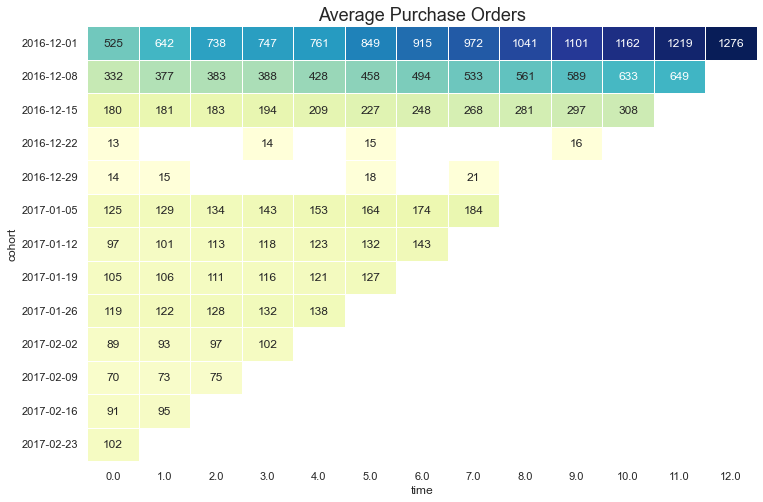

In [114]:
cohort_report_avg.index=cohort_report_avg.index.astype(str)

#creating the visualization

sns.set(style='white')
plt.figure(figsize=(12, 8))

sns.heatmap(cohort_report_avg, annot=True, cmap="YlGnBu", fmt='.0f', linewidths=1, linecolor='white',  cbar =False 
            ).set_title('Average Purchase Orders', fontsize = 18)
plt.show()

In [115]:
#Analizing the cohort performance by revenue
cohort_purchase_sum =cohorts_purchases.pivot_table(
    index='cohort', 
    columns='time', 
    values='purchase_total', 
    aggfunc='sum'
).cumsum(axis=1)

cohort_purchase_sum.round(2).head(2)#.fillna('')

time             0.0        1.0        2.0        3.0        4.0        5.0   \
cohort                                                                         
2016-12-01  132176.04  157124.13  186839.03  188058.20  190508.85  232330.18   
2016-12-08   82118.60   91447.46   92744.60   93880.77  105115.33  111262.57   

time             6.0        7.0        8.0        9.0        10.0       11.0  \
cohort                                                                         
2016-12-01  261068.06  275195.30  293420.74  320114.73  338923.85  354184.50   
2016-12-08  122761.48  132476.01  139526.99  151730.61  164476.79  169674.56   

time             12.0  
cohort                 
2016-12-01  367631.38  
2016-12-08        NaN

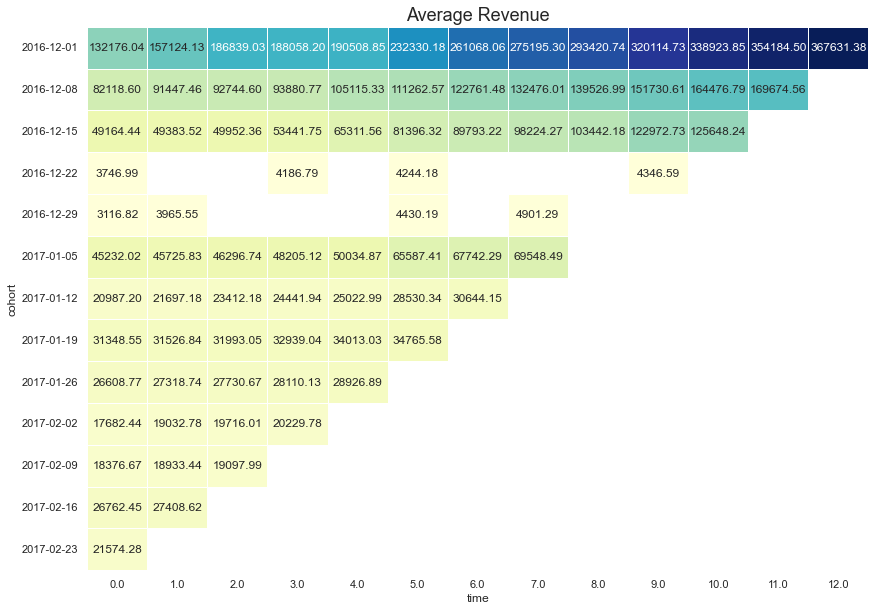

In [116]:
cohort_purchase_sum.index=cohort_purchase_sum.index.astype(str)

#creating the visualization

sns.set(style='white')
plt.figure(figsize=(14, 10))

sns.heatmap(cohort_purchase_sum, annot=True, cmap="YlGnBu", fmt='.2f', linewidths=1, linecolor='white',  cbar =False 
            ).set_title('Average Revenue', fontsize = 18)
plt.show()

In [117]:
#Analizing the cohort performance by AOV
cohort_purchase_aov =cohorts_purchases.pivot_table(
    index='cohort', 
    columns='time', 
    values='aov', 
    aggfunc='mean'
).cumsum(axis=1)

cohort_purchase_aov.round(2).head(2)#.fillna('')

time          0.0     1.0     2.0     3.0      4.0      5.0      6.0   \
cohort                                                                  
2016-12-01  251.76  465.00  774.53  909.99  1085.04  1560.28  1995.70   
2016-12-08  247.35  454.65  670.84  898.08  1178.94  1383.85  1703.26   

time           7.0      8.0      9.0      10.0     11.0     12.0  
cohort                                                            
2016-12-01  2243.55  2507.68  2952.58  3260.93  3528.66  3764.57  
2016-12-08  1952.35  2204.17  2640.02  2929.70  3254.56      NaN

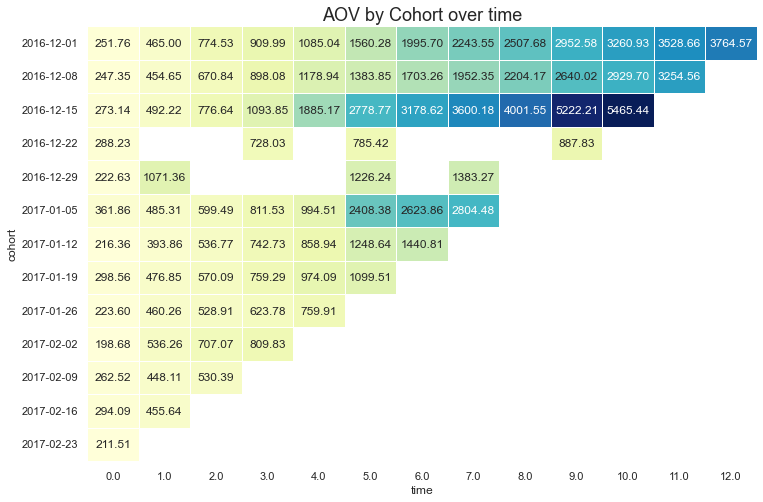

In [118]:
cohort_purchase_aov.index=cohort_purchase_aov.index.astype(str)

#creating the visualization

sns.set(style='white')
plt.figure(figsize=(12, 8))

sns.heatmap(cohort_purchase_aov, annot=True, cmap="YlGnBu", fmt='.2f', linewidths=1, linecolor='white',  cbar =False 
            ).set_title('AOV by Cohort over time', fontsize = 18)
plt.show()

In [119]:
#Analizing the cohort performance by Return Rate
cohort_purchase_rr =cohorts_purchases.pivot_table(
    index='cohort', 
    columns='time', 
    values='return_rate', 
    aggfunc='mean'
).cumsum(axis=1)

cohort_purchase_rr.round(2).head(2)#.fillna('')

time        0.0   1.0   2.0   3.0   4.0   5.0   6.0   7.0   8.0   9.0   10.0  \
cohort                                                                         
2016-12-01  1.28  1.57  1.80  1.83  1.86  2.08  2.24  2.38  2.55  2.69  2.84   
2016-12-08  1.17  1.33  1.35  1.37  1.51  1.61  1.74  1.88  1.98  2.07  2.23   

time        11.0  12.0  
cohort                  
2016-12-01  2.98  3.12  
2016-12-08  2.29   NaN

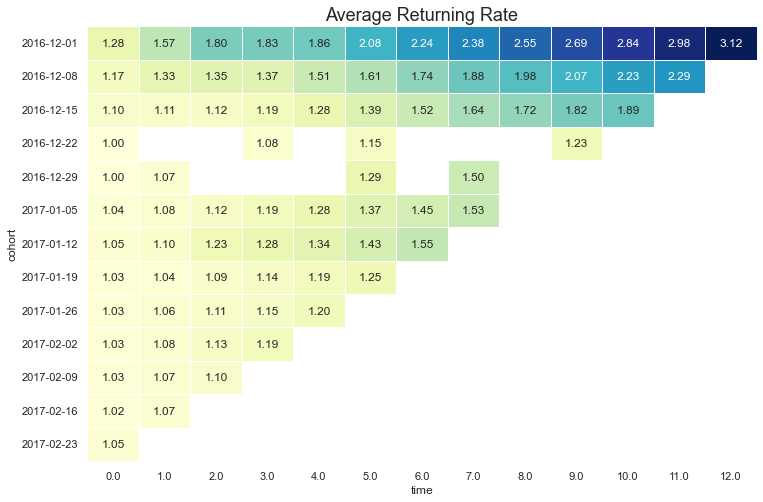

In [120]:
cohort_purchase_rr.index=cohort_purchase_rr.index.astype(str)

#creating the visualization

sns.set(style='white')
plt.figure(figsize=(12, 8))

sns.heatmap(cohort_purchase_rr, annot=True, cmap="YlGnBu", fmt='.2f', linewidths=1, linecolor='white',  cbar =False 
            ).set_title('Average Returning Rate', fontsize = 18)
plt.show()

<a class="anchor" id="s5c"></a>
## Cohort Analysis Observations

- The cohorts for the weeks of 22/12/2016 and 29/12/2016 have less then 15 users each, so we can ignore the results.
- The bigger cohort was the first from 01/12/2016 and the second from 08/12/2016 with 409 and 204 users respectively
- The best performance in absolute terms of revenue and numbers of ordes came from the first, second and third cohort
- Due the high difference about the numbers of users in each cohort, the most accurate way to analyse this cohorts is through the metrics Average Order Value (AOV) and Returning Rate (RR). 
- The higher returning rates are still from the first, second and third cohorts, where, for instance, in the week 7 the users from the first cohort bought an average of 2.38 orders, the second 1.88, and the third 1,64 purchases by user.
- The AOV is showing that the third and the sixth cohorts have a much higher value of AOV, meaning that they have less purchases, but with higher revenues per purchase.

In [121]:
cohort_return =cohorts_purchases.groupby(['cohort','users'])['purchases'].sum().reset_index()
cohort_return['return_rate']=cohort_return['purchases']/cohort_return['users']

cohort_return

cohort  users  purchases  return_rate
0  2016-12-01    409       1276     3.119804
1  2016-12-08    284        649     2.285211
2  2016-12-15    163        308     1.889571
3  2016-12-22     13         16     1.230769
4  2016-12-29     14         21     1.500000
5  2017-01-05    120        184     1.533333
6  2017-01-12     92        143     1.554348
7  2017-01-19    102        127     1.245098
8  2017-01-26    115        138     1.200000
9  2017-02-02     86        102     1.186047
10 2017-02-09     68         75     1.102941
11 2017-02-16     89         95     1.067416
12 2017-02-23     97        102     1.051546

In [122]:
## Return Rate by Cohort
cohort_return.cohort=cohort_return.cohort.astype(str)
fig = px.bar(cohort_return, x='cohort', y='return_rate',
    color = 'cohort')#, size = 'return_rate')
             
fig.add_hline(y=cohort_return['return_rate'].mean(),line_dash="dash", line_color="#c0c0c0",
             annotation_text="Average RR",
              annotation_position="top right")
         
    

fig.update_layout(
    title='Returning Rate by Cohort',
    showlegend=False,
    #plot_bgcolor="#DDFFCC",
    xaxis_title='Cohort',
    yaxis_title='Returning Rate',
    plot_bgcolor="#FFFFFF",
    xaxis_gridcolor="#cccfff",
    yaxis_gridcolor="#cccfff",
    margin=dict(t=50,l=10,b=10,r=10),
    font_color = "#1f4f79",
)
fig.show() 

<hr>

<a class="anchor" id="s5d"></a>
## Predictive Customer Lifetime Value (CLV)

Let's apply the lifetimes library to get the CLV Values for our dataset:

In [123]:
clv = lifetimes.utils.summary_data_from_transaction_data(purchases,'customerid','purchase_day','purchase_total',observation_period_end='2017-02-28')
clv

frequency  recency     T  monetary_value
customerid                                          
18026.0           1.0     50.0  83.0          295.33
18027.0           1.0     40.0  74.0          169.70
18029.0           0.0      0.0  26.0            0.00
18031.0           0.0      0.0  12.0            0.00
18035.0           0.0      0.0  41.0            0.00
...               ...      ...   ...             ...
23936.0           1.0      6.0  12.0           28.05
23938.0           0.0      0.0  82.0            0.00
23939.0           1.0     24.0  74.0          327.82
23948.0           0.0      0.0  82.0            0.00
23962.0           2.0     53.0  53.0           20.78

[1652 rows x 4 columns]

In [124]:
purchases.purchase_total[purchases.customerid ==23939.0]

1384    327.82
3761     74.72
Name: purchase_total, dtype: float64

In [125]:
clv = clv[clv['frequency']>0] # we want only customers purchased more than once
clv

frequency  recency     T  monetary_value
customerid                                          
18026.0           1.0     50.0  83.0          295.33
18027.0           1.0     40.0  74.0          169.70
18038.0           1.0     26.0  47.0          748.69
18049.0           1.0      3.0  76.0          127.09
18056.0           1.0     39.0  70.0          297.25
...               ...      ...   ...             ...
23918.0           2.0     60.0  88.0          153.52
23924.0           1.0     43.0  71.0          284.08
23936.0           1.0      6.0  12.0           28.05
23939.0           1.0     24.0  74.0          327.82
23962.0           2.0     53.0  53.0           20.78

[612 rows x 4 columns]

In [126]:
bgf = BetaGeoFitter(penalizer_coef=0.001)
bgf.fit(clv['frequency'], clv['recency'], clv['T'])

<lifetimes.BetaGeoFitter: fitted with 612 subjects, a: 0.08, alpha: 107.32, b: 0.29, r: 3.81>

<AxesSubplot:title={'center':'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

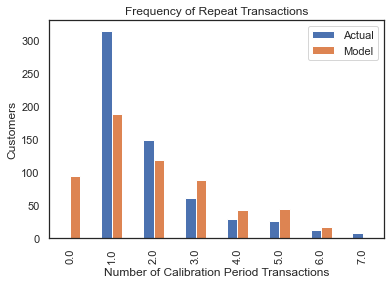

In [127]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

The model differs form our data because it is proposing a normal distribution on the Repeat Transactions. But we for the sake of the study define the minimun repeat for our data as 1, so that's the origin of the differences

In [128]:
t = 90 # 3 month period
clv['expected_purc_3_months'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, clv['frequency'], clv['recency'], clv['T'])
clv.sort_values(by='expected_purc_3_months',ascending=False).head(5)

frequency  recency     T  monetary_value  expected_purc_3_months
customerid                                                                  
20990.0          25.0     84.0  89.0      308.904400               12.888915
20285.0          22.0     88.0  89.0       49.780000               11.572087
23520.0          19.0     89.0  89.0       52.056842               10.221833
20590.0          19.0     79.0  89.0      441.606316               10.124860
18427.0          17.0     85.0  85.0      120.025882                9.508050

In [129]:
clv[['frequency','monetary_value']].corr()

frequency  monetary_value
frequency        1.000000        0.041045
monetary_value   0.041045        1.000000

In [130]:
ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(clv["frequency"],
        clv["monetary_value"])

<lifetimes.GammaGammaFitter: fitted with 612 subjects, p: 3.76, q: 0.40, v: 3.60>

In [131]:
clv['3_months_CLV']=ggf.customer_lifetime_value(bgf,
                                   clv["frequency"],
                                   clv["recency"],
                                   clv["T"],
                                   clv["monetary_value"],
                                   time=3,
                                   freq='D',
                                   discount_rate=0.01
                                                )
clv.sort_values('3_months_CLV',ascending=False).head()

frequency  recency     T  monetary_value  expected_purc_3_months  \
customerid                                                                     
20325.0           8.0     64.0  70.0      5924.68375                5.758016   
23781.0           1.0     62.0  83.0     10509.47000                1.474460   
18094.0           2.0     40.0  53.0      5388.93000                2.842184   
19835.0           5.0     82.0  87.0      3724.82200                3.886025   
23190.0           5.0     83.0  89.0      2776.47800                3.843495   

            3_months_CLV  
customerid                
20325.0     34133.576126  
23781.0     18103.333254  
18094.0     16332.575563  
19835.0     14664.725212  
23190.0     10812.139247

In [132]:
clv['segment'] =  pd.qcut(clv['3_months_CLV'],4,labels = ['hibernating','need_attention','loyal_customers', 'champions'])
clv.head()

frequency  recency     T  monetary_value  expected_purc_3_months  \
customerid                                                                     
18026.0           1.0     50.0  83.0          295.33                1.300858   
18027.0           1.0     40.0  74.0          169.70                1.317785   
18038.0           1.0     26.0  47.0          748.69                1.720587   
18049.0           1.0      3.0  76.0          127.09                0.556528   
18056.0           1.0     39.0  70.0          297.25                1.387680   

            3_months_CLV          segment  
customerid                                 
18026.0       454.143418  loyal_customers  
18027.0       266.708762   need_attention  
18038.0      1511.709114        champions  
18049.0        84.941753      hibernating  
18056.0       487.569774  loyal_customers

In [133]:
clv.groupby('segment').mean().reset_index()

segment  frequency    recency          T  monetary_value  \
0      hibernating   1.352941  36.437908  72.856209       73.609612   
1   need_attention   1.771242  47.071895  71.836601      144.636353   
2  loyal_customers   2.267974  52.006536  69.725490      230.418723   
3        champions   3.490196  60.254902  76.633987      824.802859   

   expected_purc_3_months  3_months_CLV  
0                1.559049    114.759743  
1                2.042201    289.511197  
2                2.447228    527.828962  
3                3.064623   2330.541322

- The 612 repeating customers were divided in four groups and now we can propose different approach strategies for each group, trying to engage them more with the company.
- the champions have the higher frquency and revenue, and the hobernating are the customer that are in the border line to not be a client anymore.
- The period of three months is too short to define inactive users. Is important to make a larger test based in a longer period

<hr>

<a class="anchor" id="step6"></a>
## Loyalty Program Analysis

<a class="anchor" id="s6a"></a>
### Loyalty Participation Rate

In [134]:
 purchases.customerid[purchases.loyalty_program ==1].nunique()

554

In [135]:
loyal=purchases.groupby('loyalty_program')['customerid'].nunique().reset_index()
loyal['members']=['no-loyalty program',' loyalty program']
loyal

loyalty_program  customerid             members
0                0        1098  no-loyalty program
1                1         554     loyalty program

In [136]:
fig = px.pie(loyal, values='customerid', names='members', color = 'loyalty_program',
            color_discrete_map={0:'#f3fa81',1:'#2166ac'})
fig.show()

In [137]:
LPR = purchases.customerid[purchases.loyalty_program ==1].nunique () / purchases.customerid.nunique()*100
round(LPR,2)

33.54

The store have a participation of 33.54 % of all it's customers, members of the Loyality program

<hr>

<a class="anchor" id="s6b"></a>
### Repeat Purchase Rate (RPR)

Repeat purchase rate Loyalty vs no-loyalty (RPR) RPR = Repeat customers/total buying customers 

In [138]:
repeat = purchases.groupby('customerid').agg({'loyalty_program': 'max','purchaseid': 'count'}).reset_index()
repeat['repeat'] = repeat.purchaseid-1
repeat.head(2)

customerid  loyalty_program  purchaseid  repeat
0     18026.0                0           2       1
1     18027.0                0           2       1

In [139]:
#General Repeat Purchase Rate
RPR = round(repeat.customerid[repeat.repeat>0].nunique()/repeat.customerid.nunique()*100, 2)
RPR

39.1

In [140]:
#Loyalty Repeat Purchase Rate
L_RPR = round(repeat.customerid[(repeat.repeat>0)&(repeat.loyalty_program==1)].nunique()\
              /repeat[(repeat.loyalty_program==1)].customerid.nunique()*100, 2)
L_RPR

43.32

In [141]:
# No-Loyalty Repeat Purchase Rate
N_RPR = round(repeat.customerid[(repeat.repeat>0)&(repeat.loyalty_program==0)].nunique()\
              /repeat[(repeat.loyalty_program==0)].customerid.nunique()*100, 2)
N_RPR

36.98

<hr>

<a class="anchor" id="s6c"></a>
### Loyal Customer Rate (LCR)
Let's define as our loyal customres who bought more than 3 times in the last three months independent of the participation on the Loyalty program (an average of 1 purchase per month)

In [142]:
#General Loyal Customer Rate
LCR = round(repeat.customerid[repeat.repeat>2].nunique()/repeat.customerid.nunique()*100, 2)
LCR

10.59

In [143]:
#Loyalty program members  LCR
L_LCR = round(repeat.customerid[(repeat.repeat>2)&(repeat.loyalty_program==1)].nunique()\
              /repeat[(repeat.loyalty_program==1)].customerid.nunique()*100, 2)
L_LCR

10.11

In [144]:
#No-Loyalty program members  LCR
N_LCR = round(repeat.customerid[(repeat.repeat>2)&(repeat.loyalty_program==0)].nunique()\
              /repeat[(repeat.loyalty_program==0)].customerid.nunique()*100, 2)
N_LCR

10.84

<hr>

<a class="anchor" id="s6d"></a>
### Average Order Value - AOV

In [145]:
AOV = round(sales.item_total.sum()/sales.purchaseid.nunique(),2) 
AOV

286.42

In [146]:
t_AOV = round(purchases.purchase_total.sum()/purchases.purchaseid.nunique(),2) 
t_AOV

285.66

In [147]:
l_AOV= round(purchases.purchase_total[purchases.loyalty_program==1].sum()\
             /purchases.purchaseid[purchases.loyalty_program==1].nunique(),2) 
l_AOV

250.02

In [148]:
n_AOV= round(purchases.purchase_total[purchases.loyalty_program==0].sum()\
             /purchases.purchaseid[purchases.loyalty_program==0].nunique(),2) 
n_AOV

303.41

<hr>

<a class="anchor" id="s6e"></a>
### Loyalty Program Observations
- The store chain has  an Repeat Purchase Rate of 39.1%
- Members of the Loyalty Program have a higher RPR (43%) than the non-members of the program (37%)
- We define our loyal members as clients who purchased more than three times during the period, independent of their participation in the Loyalty program.
- The Loyal Customer rate for the Dataset is 10.59%
- Members of the Loyalty Program have a bit lower LCR (10.11%) than the non-members of the program (10.84%)
- The AOV for all dataset is around 286.00 (Including and excluding the 'no_id' customers)
- The AOV for the members of the loyalty program is lower (250.00) than the non-participants (303.00) 
- The data is indicating that even that the loyalty members are buying more frequently, their purchase values are smaller than the non-mebers purchases

<hr>

<a class="anchor" id="step7"></a>
## Hypothesis on the Equality of the member and non-members of the Loyalty Program
Two sample t-test is relatively robust to the assumption of normality and homogeneity of variances when sample size is large (n ≥ 30) and there are equal number of samples (n1 = n2) in both groups

In [149]:
hypo_samples=purchases.groupby('customerid').agg({'loyalty_program':'max', 'purchase_total' : 'sum'})
hypo_samples.head(5)

loyalty_program  purchase_total
customerid                                 
18026.0                   0          751.11
18027.0                   0          738.15
18029.0                   0          194.36
18031.0                   0          152.07
18035.0                   0         1488.12

In [150]:
#Group Samples
loyal_sample = hypo_samples.purchase_total[hypo_samples.loyalty_program==1].sample(100, random_state=1)
normal_sample =hypo_samples.purchase_total[hypo_samples.loyalty_program==0].sample(100, random_state=1) 

H0 The purchase average for the members of the loyalty program and the non members are the same<br>
H1 The purchase average for the members of the loyalty program and the non members are different

In [151]:
alpha = 0.05  # critical statistical significance level
# if the p-value is less than alpha, we reject the hypothesis

results = st.ttest_ind(loyal_sample, normal_sample)

print('p-value: ', results.pvalue)

if results.pvalue < alpha:
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis") 

p-value:  0.14064438826994205
We can't reject the null hypothesis


There results are not showing any statistical difference between the average purchases from the members and non members of the Loyalty program.

Maybe the company has to make a broader study on the loyalty program performance (For instance, calculating Redemption Rates for the points,Active Engagement Rates for the promotions and Customer Retention Rate in a determinated period)and to get decisions on how to strenght the loyalty program to increase the revenue in the shops

<hr>

<a class="anchor" id="step8"></a>
# Shops Study

In [152]:
sales.head(2)

purchaseid item_id  quantity        purchasedate customerid  \
0     538280   21873        11 2016-12-10 12:50:00    18427.0   
2     540418   21873         1 2017-01-07 11:04:00      no_id   

   loyalty_program  shopid purchase_day       week  week_day     month  \
0                0  Shop 3   2016-12-10 2016-12-08  Saturday  December   
2                0  Shop 0   2017-01-07 2017-01-05  Saturday   January   

  productid  price_per_one  item_total  purchase_total  
0     21873           0.42        4.62          572.67  
2     21873           0.42        0.42          811.94

In [153]:
#Dropping out the duplictes for the calcultaions
sales_shop = sales.drop_duplicates(subset=['purchaseid']).reset_index(drop=True)

In [154]:
sales_shop.shape

(3515, 15)

In [155]:
shops = purchases.groupby(['week','shopid'])\
.agg({'customerid':'nunique','purchaseid':'nunique','purchase_total':'sum'}).reset_index()
#shops = shops.reindex([0,1,12,23,25,26,27,28,29,30,2,3,4,5,6,7,8,9,10,11,13,14,15,16,17,18,19,20,21,22,24]).reset_index(drop=True)
shops.head()

week   shopid  customerid  purchaseid  purchase_total
0 2016-12-01   Shop 0          17          17         7179.99
1 2016-12-01   Shop 1          16          16         2310.94
2 2016-12-01  Shop 10          23          25         7606.19
3 2016-12-01  Shop 11          16          16         2466.22
4 2016-12-01  Shop 12          13          13         1712.79

In [156]:
shops = sales.groupby(['week','shopid'])\
.agg({'customerid':'nunique','purchaseid':'nunique','item_total':'sum'}).reset_index()
#shops = shops.reindex([0,1,12,23,25,26,27,28,29,30,2,3,4,5,6,7,8,9,10,11,13,14,15,16,17,18,19,20,21,22,24]).reset_index(drop=True)
shops.head()

week   shopid  customerid  purchaseid  item_total
0 2016-12-01   Shop 0          18          46    22651.55
1 2016-12-01   Shop 1          16          16     2310.94
2 2016-12-01  Shop 10          23          25     7606.19
3 2016-12-01  Shop 11          16          16     2466.22
4 2016-12-01  Shop 12          13          13     1712.79

In [157]:
fig = px.line(shops,x="week", y="purchaseid",title=' Weekly Purchases by shop (no_id included)', color ='shopid', 
             color_discrete_sequence=px.colors.qualitative.Alphabet)
#adding reference line
#fig.add_trace(y=shops['purchaseid'].mean(),line_dash="dash", line_color="#c0c0c0")
fig.update_layout(
    showlegend=True,
    plot_bgcolor="#FFFFFF",
    xaxis_gridcolor="#cccfff",
    yaxis_gridcolor="#cccfff",
    margin=dict(t=50,l=10,b=10,r=10)
)
fig.show()

In [158]:
shops_top = shops.groupby('shopid')['customerid','purchaseid','item_total'].sum().reset_index()
shops_top = shops_top.reindex([0,1,12,23,25,26,27,28,29,30,2,3,4,5,6,7,8,9,10,11,13,14,15,16,17,18,19,20,21,22,24]).reset_index(drop=True)
shops_top['shop_AOV']= shops_top.item_total / shops_top.purchaseid
shops_top.head(6)

shopid  customerid  purchaseid  item_total    shop_AOV
0  Shop 0         125         383   106375.42  277.742611
1  Shop 1         114         114    25074.96  219.955789
2  Shop 2         100         100    25425.23  254.252300
3  Shop 3          83          85    28684.51  337.464824
4  Shop 4         103         103    40451.41  392.732136
5  Shop 5         119         120    63457.26  528.810500

In [159]:
fig = px.bar(shops_top, x='shopid', y='purchaseid',
    color = 'shopid', color_discrete_sequence=px.colors.qualitative.Alphabet,
    
)

fig.add_hline(y=shops_top.purchaseid.mean(),line_dash="dash", line_color="#c0c0c0")


fig.update_layout(
    title='Same Store Sales - quantity of purchases',
    showlegend=True,
    plot_bgcolor="#FFFFFF",
    xaxis_gridcolor="#cccfff",
    yaxis_gridcolor="#cccfff",
    margin=dict(t=50,l=10,b=10,r=10),
    font_color = "#1f4f79"
)
fig.show() 

In [160]:
fig = px.bar(shops_top, x='shopid', y='item_total',
    color = 'shopid', color_discrete_sequence=px.colors.qualitative.Alphabet,
    
)

fig.add_hline(y=shops_top.item_total.mean(),line_dash="dash", line_color="#c0c0c0")


fig.update_layout(
    title='Same Store Sales - value $',
    showlegend=True,
     plot_bgcolor="#FFFFFF",
    xaxis_gridcolor="#cccfff",
    yaxis_gridcolor="#cccfff",
    margin=dict(t=50,l=10,b=10,r=10),
    font_color = "#1f4f79"
)
fig.show() 

In [161]:
fig = px.bar(shops_top, x='shopid', y='shop_AOV',
    color = 'shopid', color_discrete_sequence=px.colors.qualitative.Alphabet,
    
)

fig.add_hline(y=shops_top.shop_AOV.mean(),line_dash="dash", line_color="#c0c0c0")


fig.update_layout(
    title='AOV by Shop',
    showlegend=True,
     plot_bgcolor="#FFFFFF",
    xaxis_gridcolor="#cccfff",
    yaxis_gridcolor="#cccfff",
    margin=dict(t=50,l=10,b=10,r=10),
    font_color = "#1f4f79"
)
fig.show() 

- The Shop 0 has the higher values in Purchases and Revenues with three times more than the average
- It's important to understand why this outlet has too much activity. (Maybe online sales?)
- When looking to the AOV, Shop 5 has the best performance followed by Shop 25 and Shop 4

<hr>

<a class="anchor" id="s8a"></a>
### Best day of the week to sell

In [162]:
week_shop = sales.groupby(['shopid','week_day' ]).agg({'item_total':'sum' , 'customerid':'nunique' ,\
                                        'purchaseid':'nunique'}).reset_index()
week_shop.head()

shopid  week_day  item_total  customerid  purchaseid
0  Shop 0    Friday    16096.83          24          67
1  Shop 0    Monday     1430.71          10          12
2  Shop 0  Saturday    25255.67          16          70
3  Shop 0  Thursday    18280.76          30          74
4  Shop 0   Tuesday    20794.12          17          67

In [163]:
lmax=[]
for s in week_shop.shopid.unique():
    a =week_shop[(week_shop.shopid==s)\
                     &(week_shop.item_total==week_shop.item_total[week_shop.shopid==s].max())].index.max()
    lmax.append(a)
for d in week_shop.index:
    if d not in lmax:
        week_shop = week_shop.drop(d)


In [164]:
week_shop= week_shop.reset_index(drop=True)
week_shop= week_shop.reindex([0,1,12,23,25,26,27,28,29,30,2,3,4,5,6,7,8,9,10,11,13,14,15,16,17,18,19,20,21,22,24])    
week_shop= week_shop.reset_index(drop=True)

week_shop.head()

shopid   week_day  item_total  customerid  purchaseid
0  Shop 0   Saturday    25255.67          16          70
1  Shop 1  Wednesday     6208.66          16          16
2  Shop 2     Friday     6704.16          23          23
3  Shop 3   Saturday     8213.67          17          18
4  Shop 4    Tuesday    14254.91          15          16

In [165]:
fig = px.bar(week_shop, x='week_day', y='shopid',color = 'shopid',
             color_discrete_sequence=px.colors.qualitative.Alphabet, text="shopid", 
             

    )

fig.update_layout(
    title='Best day of the week to sell',
    showlegend=False,
     plot_bgcolor="#FFFFFF",
    xaxis_gridcolor="#cccfff",
    yaxis_gridcolor="#cccfff",
    margin=dict(t=50,l=10,b=10,r=10),
    font_color = "#1f4f79"
)
fig.show() 

- The best day of the week to sell is Friday for 8 shops.
- Saturday and Thursday is the best day for 6 shops each and 5 shops on Wednesday and Tuesday
- No shop have Monday as the best day to sell

<hr>

<a class="anchor" id="step9"></a>
# General Conclusions

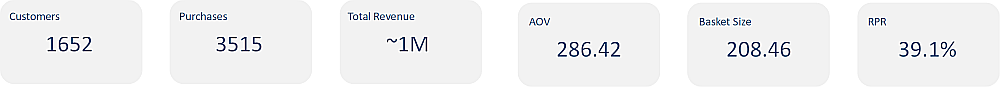

<hr>

The total weekly average of purchases was 270 with an average revenue of around 77440.00.

The data showed a  decrease in the performance during the period.MoM shows a gradual decrease of ~10% From December to February.

Fridays showed the greatest number of purchases, but Wednesdays gathered the highest sales revenue.

The analysis cohort shows that users from 15/12/2016 have the best AOV  and the first, second and third cohorts have the highest returning rates.

The LCV study classified the 612 repeating customers in four groups so we can propose different approach strategies for each group, trying to engage them more with the company.

The top 5 selling products are distinct than the top 5 revenue products, meaning that the higher sold items didn't allways brought the higher revenue.

33% of the customers are part of the loyalty program, but there is no significative difference between both groups. The company have to review the strategy to strenght the program and fidelize more customers.

Shop 0 has the higher values in Purchases and Revenues,  and  Shop 5 has the best AOV performance followed by Shop 25 and Shop 4.

<hr><br><br><br><br><br><hr>

<a class="anchor" id="A1"></a>
## Decomposition (Annex 01)

- Define the goal
- Specify details
- Propose hypotheses
- Clear action plan
- Mandatory stages of analysis
 - Data preprocessing
 - Exploratory data analysis

### Goal:
 Assess the performance of the chain's sales outlets from the building-material retailer Home World.

### Details:

-  The data brings purchases made at the different shops of building-material retailer Home World
-  All of its customers have membership cards
-  members of the store's loyalty program pay 20,00 per month. (The program includes discounts, information on special offers, and gifts.)
-  The shop have 31 different stores
-  The data cointains operations in a period of 3 months from December 2016 to February 2017.
-  The shops are open from Monday to Saturday, closing on Sundays


### Hypotheses:


- Check the performance per period - discover if some days have more sales than others ✅
-  Is there a better day of the week for the sales?✅
-  What are the best selling products?✅
-  Discover the purchases customer behavior ✅
-  The loyalty program members are buying more than not members?✅
-  What are the shops with better performance?✅






### Action plan:

-  Data preprocessing ✅
-  Exploratory data analysis ✅
-  Check  the general purchases over the dates ✅
-  Check  the best selling products ✅
-  Prepare a cohort analysis by first purchase ✅
-  Assess the general purchases by customers (CLV) ✅
-  Loyalty Program Metrics✅
-  Check the statistical difference about the purchases of loyalty program members and not members ✅
-  Assess the performance of each of the chain's outlets sales by date and customers and compare.✅



<hr><br><br><br>

<a class="anchor" id="A2"></a>
## Documentation (Annex 02)

#### Theoretical Embasement on retail metrics

[Measuring retail supply chain performance](http://library.tuit.uz/knigiPDF/Emerald/10-1017.pdf) 

[The Top 16 Retail Metrics and How to Measure Them For Your Store](https://www.shopify.com/retail/retail-metrics)

[8 Important Metrics for Retail Industry KPIs](https://www.tableau.com/learn/articles/retail-industry-metrics-kpis)

#### Loyalty programs evaluation

[6 Metrics Important to Understanding your Loyalty Program's Success](https://blog.smile.io/6-metrics-important-to-understanding-your-loyalty-programs-success/)

#### Cohort Analysis on retail

[5 Ways Cohort Analysis Can Help You Grow Your E-Commerce Store](https://onlinesales.ai/blog/5-ways-cohort-analysis-can-help-you-grow-your-e-commerce-store/)

#### Week-on-Week metric

[Week-on-Week](https://theonlineadvertisingguide.com/glossary/week-on-week/)

#### Customer Lifetime Value

[How to Calculate Customer Lifetime Value](https://blog.hubspot.com/service/how-to-calculate-customer-lifetime-value)

[Customer Lifetime Value Prediction in Python](https://medium.com/@ugursavci/customer-lifetime-value-prediction-in-python-89e4a50df12e)

[Buy ‘Til You Die: Predict Customer Lifetime Value in Python](https://towardsdatascience.com/buy-til-you-die-predict-customer-lifetime-value-in-python-9701bfd4ddc0)
 

<hr><br><br><br>

<a class="anchor" id="A3"></a>
## Metrics To find - checklist (Annex 03)

1)  Average order value ✅ <br> 
    Total Revenue / Number of Orders
    <hr>
2)  Basket size ✅ <br>
    Total Number of Units Sold / Total Number of Transactions

 <hr>
3) month-over-month (MOM) growth WOW ✅ <br>
   ((Current Month’s Sales - Previous Month’s Sales) / Previous Month’s Sales) x 100 
 <hr>
 
4) Same-store sales ✅ <br>
    Same-store sales is a retail metric used to evaluate the total dollar number of sales in stores that have been operating for more than one year. It provides a performance comparison for established stores in a retail chain over a specific period of time.
  <hr>
  
5) Loyalty Participation Rate (PR) Loyal Customer Rate ✅ <br> 
    Number of members / Number of customers<hr>
    
6) Loyal Customer Rate LCR ✅ <br>
   Define parameter:3 orders or more
   Number of members / Number of customers<hr>

7) Repeat purchase rate RPR (General and Loyalty vs no-loyalty)✅<br>
    RPR = Repeat customers/total buying customers<hr> 
    
8) Customer lifetime value✅<br>
    Customer lifetime value (CLV) <hr>
    <br><br><br>


<a class="anchor" id="A4"></a>
##  Links for external visualizations (Annex 04)


### [Tableau Dashboard](https://tabsoft.co/3Sd1juO)  

### [Study Presentation (PDF)](https://bit.ly/3SiYzfi) 

<br>




In [166]:
#Exporting dataset to work in Tableau

sales.to_csv('sales_tableau.csv')
purchases.to_csv('purchases_tableau.csv')

<hr>

<a class="anchor" id="A5"></a>
## Extra - Printing Cashier Receipts (Annex 05)

#### Let's create a "receipt printer" to show the receipts from the purchase identification

In [171]:
def receipt(pid):
    '''
    This function will build receipts from the purchaseid.

    '''   
    
    for i in sales.index:
        if pid == sales.loc[i, 'purchaseid']:

            print('Bill number:',sales['purchaseid'][i])
            print('Date:',sales['purchasedate'][i])
            print('Shop:',sales['shopid'][i])
            print('Customer:',sales['customerid'][i])
            print("")
            print('******************************')
            print()
            print(' Code ' , '-----------', 'Price', '----------','Qty', '-----------', 'Sum' )
            for j in list(sales[sales.purchaseid == pid].index):
                print(sales['productid'][j] , '------------', sales['price_per_one'][j], '-----------',sales['quantity'][j], '-------------',round(sales['item_total'][j]),2 )
            print()
            print('******************************')
            print('Total',sales['purchase_total'][i] )
            print("")
            print('******************************')
            print()
            print('Thanks you for buying in ', sales['shopid'][i])
            break
        


In [172]:
receipt('543272')

Bill number: 543272
Date: 2017-02-06 11:11:00
Shop: Shop 14
Customer: 20489.0

******************************

 Code  ----------- Price ---------- Qty ----------- Sum
82494L ------------ 2.55 ----------- 5 ------------- 13 2
22630 ------------ 1.65 ----------- 1 ------------- 2 2
82482 ------------ 2.1 ----------- 1 ------------- 2 2
22727 ------------ 3.39 ----------- 1 ------------- 3 2
22385 ------------ 1.65 ----------- 4 ------------- 7 2
21929 ------------ 1.65 ----------- 9 ------------- 15 2
22554 ------------ 1.45 ----------- 1 ------------- 1 2
22411 ------------ 1.65 ----------- 9 ------------- 15 2
22629 ------------ 1.65 ----------- 1 ------------- 2 2
22804 ------------ 2.46 ----------- 3 ------------- 7 2
22726 ------------ 3.75 ----------- 1 ------------- 4 2
22662 ------------ 1.45 ----------- 2 ------------- 3 2
22551 ------------ 1.45 ----------- 2 ------------- 3 2
22663 ------------ 1.65 ----------- 4 ------------- 7 2

******************************
Total 82.82

*

In [173]:
receipt('536365')

Bill number: 536365
Date: 2016-12-01 08:26:00
Shop: Shop 27
Customer: 23529.0

******************************

 Code  ----------- Price ---------- Qty ----------- Sum
84029G ------------ 3.39 ----------- 5 ------------- 17 2
22752 ------------ 7.65 ----------- 1 ------------- 8 2
71053 ------------ 3.39 ----------- 5 ------------- 17 2
21730 ------------ 4.25 ----------- 5 ------------- 21 2

******************************
Total 62.8

******************************

Thanks you for buying in  Shop 27


In [174]:
receipt('539739')

Bill number: 539739
Date: 2016-12-21 15:19:00
Shop: Shop 0
Customer: no_id

******************************

 Code  ----------- Price ---------- Qty ----------- Sum
22197 ------------ 0.72 ----------- 5 ------------- 4 2
21257 ------------ 6.95 ----------- 1 ------------- 7 2
22630 ------------ 1.65 ----------- 1 ------------- 2 2
21216 ------------ 4.25 ----------- 1 ------------- 4 2
22179 ------------ 5.95 ----------- 2 ------------- 12 2
22960 ------------ 3.75 ----------- 1 ------------- 4 2
21949 ------------ 1.06 ----------- 1 ------------- 1 2
21935 ------------ 1.45 ----------- 1 ------------- 1 2
22386 ------------ 1.65 ----------- 1 ------------- 2 2
21218 ------------ 3.25 ----------- 3 ------------- 10 2
21928 ------------ 1.65 ----------- 1 ------------- 2 2
22355 ------------ 0.72 ----------- 19 ------------- 14 2
21041 ------------ 2.95 ----------- 2 ------------- 6 2
22311 ------------ 2.95 ----------- 1 ------------- 3 2
22196 ------------ 0.85 ----------- 3 ----------

In [175]:
sales.loc[1259, 'purchaseid']

'539739'

In [176]:
monday13= sales.purchaseid[(sales.loyalty_program==1)&(sales.shopid=='Shop 13')&(sales.week_day=="Monday")].unique()

In [177]:
#getting the receipts for the clients members of the Loyalty program that bought on a Monday in Shop 13
for i in monday13:
    receipt(i)
    print()
    print()
    print('######################################################')
    print()
    print()

Bill number: 545039
Date: 2017-02-27 10:22:00
Shop: Shop 13
Customer: 22922.0

******************************

 Code  ----------- Price ---------- Qty ----------- Sum
22965 ------------ 1.85 ----------- 3 ------------- 6 2
82494L ------------ 2.55 ----------- 5 ------------- 13 2
84380 ------------ 1.06 ----------- 3 ------------- 3 2
72802C ------------ 3.81 ----------- 5 ------------- 19 2
22988 ------------ 1.06 ----------- 8 ------------- 8 2
47559B ------------ 1.06 ----------- 3 ------------- 3 2
84378 ------------ 1.06 ----------- 3 ------------- 3 2
22166 ------------ 7.46 ----------- 1 ------------- 7 2
22906 ------------ 1.45 ----------- 59 ------------- 86 2
22167 ------------ 8.29 ----------- 1 ------------- 8 2
72803A ------------ 4.25 ----------- 11 ------------- 47 2
84508B ------------ 2.55 ----------- 1 ------------- 3 2
22561 ------------ 1.45 ----------- 23 ------------- 33 2

******************************
Total 239.32

******************************

Thanks you for

Bill number: 539477
Date: 2016-12-19 14:58:00
Shop: Shop 13
Customer: 23924.0

******************************

 Code  ----------- Price ---------- Qty ----------- Sum
21012 ------------ 2.1 ----------- 5 ------------- 10 2
22855 ------------ 1.06 ----------- 11 ------------- 12 2
22969 ------------ 1.25 ----------- 11 ------------- 14 2
47566 ------------ 3.75 ----------- 4 ------------- 15 2
84030E ------------ 3.75 ----------- 3 ------------- 11 2
21992 ------------ 2.46 ----------- 5 ------------- 12 2
22035 ------------ 0.36 ----------- 11 ------------- 4 2
35471D ------------ 1.25 ----------- 11 ------------- 14 2
22857 ------------ 0.72 ----------- 11 ------------- 8 2
84247G ------------ 0.42 ----------- 11 ------------- 5 2
84817 ------------ 0.42 ----------- 5 ------------- 2 2
22726 ------------ 3.75 ----------- 3 ------------- 11 2
22814 ------------ 0.36 ----------- 11 ------------- 4 2
22815 ------------ 0.36 ----------- 11 ------------- 4 2
84946 ------------ 1.06 -------

<hr> <br><br><br> <hr>